In [10]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.keras.layers import Dense,Conv2D,Input,Flatten,Reshape,Conv2DTranspose

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [86]:
def rgb2gray(rgb):
     return np.dot(rgb[:,:,:], [0.2989, 0.5870, 0.1140])

In [87]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

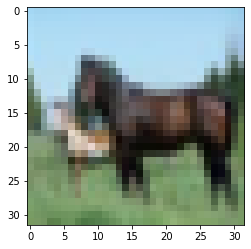

In [88]:
plt.imshow(x_train[12])

In [89]:
imrows = x_train.shape[1]
imcols=x_train.shape[2]
imchannels = x_train.shape[3]

In [90]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

In [91]:
x_train_gray.shape

(50000, 32, 32)

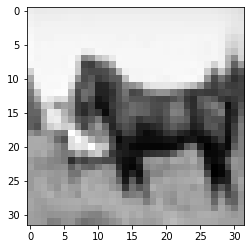

In [92]:
plt.imshow(x_train_gray[12],cmap='gray')

In [93]:
#normalize vals bw 0 to 1
x_train = x_train/255
x_test = x_test/255
x_train_gray= x_train_gray/255
x_test_gray = x_test_gray/255


In [94]:
x_train_gray = np.reshape(x_train_gray,(-1,imrows,imcols,1))
x_test_gray = np.reshape(x_test_gray,(-1,imrows,imcols,1))
layers = [64,128,256]

In [95]:
inputs = Input(shape=(imrows,imcols,1))
x=inputs
for layer in layers:
    x = Conv2D(filters=layer,kernel_size=3,strides=2,activation='relu',padding='same')(x) #half w,h
#op for cifar- 4*4*256
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(256)(x)


    




In [96]:
encoder  = Model(inputs,latent)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

In [97]:
#decoder
ipdec = Input(shape=(256,))
y=ipdec
y = Dense(shape[1]*shape[2]*shape[3])(y)
y = Reshape((shape[1],shape[2],shape[3]))(y)
#y is now 4*4*256
for layer in layers[::-1]:
    y = Conv2DTranspose(filters=layer,kernel_size=3,strides=2,padding='same',activation='relu')(y)
#y is now 32*32*64
op = Conv2DTranspose(filters=3,kernel_size=3,activation='sigmoid',padding='same')(y)
    
    


In [98]:
decoder = Model(ipdec,op)
decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 32, 32, 3)         1731

In [99]:
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
model_4 (Model)              (None, 256)               1418496   
_________________________________________________________________
model_5 (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [133]:
checkpoint = ModelCheckpoint(filepath='bestweights.h5',monitor='val_loss',verbose=1,save_best_only=True)
autoencoder.compile(loss='mse',optimizer='adam')
lrreduce = ReduceLROnPlateau(factor=np.sqrt(0.1),verbose=1,min_lr=0.5e-6)
callbacks=[lrreduce,checkpoint]




In [136]:
autoencoder.load_weights('bestweights.h5')

In [137]:
autoencoder.fit(x_train_gray,x_train,validation_data=(x_test_gray,x_test),epochs=15,batch_size=64,callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
49984/50000 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 00001: val_loss did not improve from 0.00769
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0066 - val_loss: 0.0079
Epoch 2/15
49920/50000 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 00002: val_loss improved from 0.00769 to 0.00764, saving model to bestweights.h5
50000/50000 [==============================] - 36s 727us/sample - loss: 0.0063 - val_loss: 0.0076
Epoch 3/15
49984/50000 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00003: val_loss did not improve from 0.00764
50000/50000 [==============================] - 33s 668us/sample - loss: 0.0061 - val_loss: 0.0077
Epoch 4/15
49984/50000 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 00004: val_loss improved from 0.00764 to 0.00759, saving model to bestweights.h5
50000/50000 [==============================] - 34s 687us/s

In [139]:
colored_images = autoencoder.predict(x_test_gray)

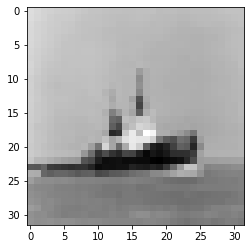

In [180]:
plt.imshow(np.reshape(x_test_gray[72],(32,32)),cmap='gray')

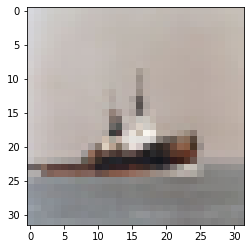

In [182]:
plt.imshow(x_test[72],cmap='gray')

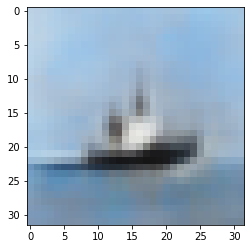

In [183]:
plt.imshow(colored_images[72],cmap='gray') #predicted image.


In [138]:
autoencoder.load_weights('bestweights.h5')